### CartPole-1 Training Notebook v1

Contains the code and methodology to train a continual-learning CartPole model using a DQN

**Imports**

In [ ]:
import gymnasium as gym
import math
import random
import time
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
env = gym.make('CartPole-v1')

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [ ]:
# Assign the device to CPU or GPU if available
device = torch.device(
    'cuda' if torch.cuda.is_available() else
    'cpu'
)

print(f'Selected device: {device}')

Selected device: cuda


#### Replay Memory

Replay memory stores past 'Transition' states into a buffer of 10,000 of the latest experiences. These transitions are used to optimize the policy network.

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        # Creates a deque object storing type array with a capacity
        # Once capacity is reached, old experiences will automatically be overwriteen with the new
        self.memory = deque([], maxlen=capacity)

    # Save the transition to the memory
    def push(self, *args):
        self.memory.append(Transition(*args))

    # Return batch_size samples for use in optimization 
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [6]:
# Import the model used
from CartPole_DQN_model import CartPoleModel

#### Pre-Training Setup

Define variables needed during training. Initialize the memory buffer, and policy and target networks

In [7]:
BATCH_SIZE = 128
GAMMA = 0.99 # Discount factor on future states

# Epsilon-greedy variables needed
EPS_START = 0.9 # Start off encouraging the model to explore
EPS_END = 0.05 # After exploring, the model will stabilize and rarely explore
EPS_DECAY = 1000 # Rate at which the epsilon threshold will decrease (exponent)

TAU = 0.005 # Rate at which the target network will be updated
LR = 1e-4 # Learning rate of the policy net

# Retrieve the number of actions possible in the environment (2 - Left or Right)
n_actions = env.action_space.n

# Initialize the env state and store as variable
state, _ = env.reset()

# Store the number of variables inside the observation space
# This means we store each input variable being passed into the model
# In CartPole-v1 there are 4 (position, velocity, and 2 more idk)
n_observations = len(state)

# Number of nodes in each layer of the neural net
n_nodes = 128 

# Instantiate both the policy and target net
policy_network = CartPoleModel(n_observations, n_actions, n_nodes)
target_network = CartPoleModel(n_observations, n_actions, n_nodes)

# Set the target network weights to the same as policy net 
target_network.load_state_dict(policy_network.state_dict())

# Send models to the GPU (or CPU)
policy_network.to(device)
target_network.to(device)

optimizer = optim.AdamW(policy_network.parameters(), lr=LR, amsgrad=True)

# Create the Experience replay buffer with a cap of 10,000
memory = ReplayMemory(10_000)

In [8]:
# Define the method that selects an e-greedy action

steps_done = 0

def select_action(sate):
    global steps_done

    # Random number
    # If number is above eps_threshold, select greedy action (highest q-value)
    # Otherwise choose a random action to explore
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)

    # Greedy select here
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # PAss the state through the model without gradient descent (we're not learning here, just need an action)
            # Select the max Q-Value (action) the model chose and return the reshaped index of said action
            return policy_network(state).max(1).indices.view(1, 1)
    else:
        # If random action is selected, choose a random action from env, and send to device
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)    


#### Plotting Definition

In [9]:
episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf() # Clear current figure
        plt.title('Training...')

    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    # Additionally, start plotting the mean after 100 episodes
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

#### Model Optimization

This is where the learning of the policy_network occurs

In [ ]:
def optimize_model():

    # If we don't have BATCH_SIZE number of experiences yet
    # We can't optimize the model, so skip until false
    if len(memory) < BATCH_SIZE:
        return
    
    # Select a BATCH_SIZE number of experiences (at random) from memory
    transitions = memory.sample(BATCH_SIZE)

    # Reshape array of tuple Transitions into array of tensor transitions
    # Combine into a single Transition capable of being batch processed
    # I don't really get this line. Just reshapes and redefines
    batch = Transition(*zip(*transitions))

    # Now we store a mask of all the non-terminal states within the batch
    non_terminal_mask = torch.tensor(
        # For every state, if it's not terminal, return the next_state
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool
    )

    # Extract all the non-terminal next_states from the batch
    non_terminal_next_states = torch.cat([s for s in batch.next_state if s is not None])

    # Store the state, action, and reward of each item in the batch
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Forward pass the policy_network to see what actions the model thinks should be taken
    # Take the q-value for what action actually was taken (based on the experience)
    # gather(1, action_batch) just matches index of action to index of q-value of network output 
    state_action_values = policy_network(state_batch).gather(1, action_batch)

    # For non-terminal states, we need to forward pass the target model to see what the future q-value will be
    next_states_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        # forward pass the target model and take the MAX Q-Value
        # Only do this for next_states that don't terminate
        next_states_values[non_terminal_mask] = target_network(non_terminal_next_states).max(1).values
    
    # Bellman equation
    expected_state_action_values = (next_states_values * GAMMA) + reward_batch

    # Calculate the Huber Loss (acts like MSE when low, and MAE when high for stability)
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimze model
    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(policy_network.parameters(), 100)
    optimizer.step()

#### Training Loop

Complete


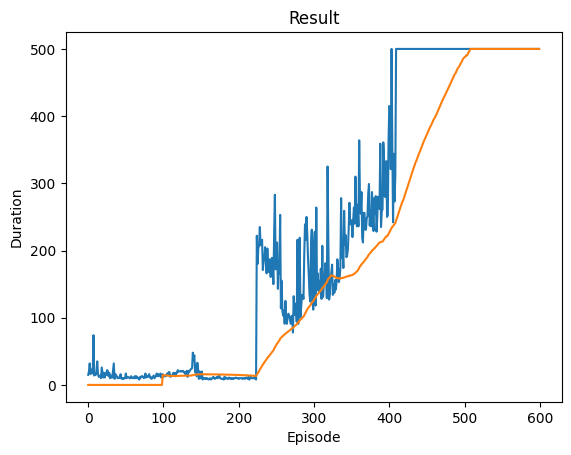

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):

    # Reset env and store the state
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count(1):
        # Select the action to take (e-greedy)
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        # Update the next_state
        # Convert to tensor as prep for model 
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        
        # Save the current transition into memory
        memory.push(state, action, next_state, reward)

        # Move to next state
        state = next_state

        # Apply model optimization (Bellman)
        optimize_model()

        # Soft update the target network
        target_net_state_dict = target_network.state_dict()
        policy_net_state_dict = policy_network.state_dict()

        # Take the weights of the current target net and nudge them toward the policy net very slowly
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU \
                + target_net_state_dict[key] * (1 - TAU)
        
        target_network.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [12]:
# Save the model for simulation in other .py file
torch.save(policy_network.state_dict(), './models/policy_model.pt')

In [ ]:
# # This will save as a video as mp4
# env = gym.make('CartPole-v1', render_mode='rgb_array')
# env = gym.wrappers.RecordVideo(env, video_folder='./videos', episode_trigger=lambda ep: True)